# Progress Task 1: Prediction of wine quality

## Introduction

This progress task has the aim to predict the quality of wine based on its physicochemical properties. The dataset used in this task is the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository. Credits to *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

The objective of this task is to select an apropiate regression and classification model and compare them.

## Prepare environmental variables

Download the dataset and import the necessary packages.

In [ ]:
%pip install ucimlrepo seaborn matplotlib scikit-learn pandas numpy pygam

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [2]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

## Exploratory Data Analysis (EDA)

In this section, a brief exploratory data analysis (EDA) will be performed on the dataset, prior to correctly pre-process it and capture the most relevant features for model training.

### Describing the dataset

In [ ]:
# Check the number of instances and the number of features
print ("Shape of data:", X.shape , y.shape)

In [ ]:
# Print the first rows of the features
print("=================== Feature's First Rows ===================\n", X.head(3), "\n")

# Print the first rows of the target
print("=================== Target's First Rows ===================\n", y.head(3), "\n")

In [ ]:
# Check for missing values
print("=================== Null value count ===================\n",df_wine.isnull().sum(), "\n")

In [ ]:
df_wine.describe(percentiles=[])

Now that we have taken a look into the dataset, here's a summary:

The dataset consists of 11 continuous features, none of them with missing values. The features are: 

* `fixed_acidity`: with values ranging from 4.6 to 15.9.
* `volatile_acidity`: with values ranging from 0.12 to 1.58.
* `citric_acid`: with values ranging from 0 to 1.66.
* `residual_sugar`: with values ranging from 0.6 to 65.8.
* `chlorides`: with values ranging from 0.009 to 0.611.
* `free_sulfur_dioxide`: with values ranging from 1 to 289.
* `total_sulfur_dioxide`: with values ranging from 6 to 440.
* `density`: with values ranging from 0.99 to 1.003.
* `pH`: with values ranging from 2.74 to 4.01.
* `sulphates`: with values ranging from 0.33 to 2.
* `alcohol`: with values ranging from 8.4 to 14.9.

The target variable is:
* `quality`: is an integer variable, from 0 to 10 but in this dataset it ranges from 3 to 9.

Now that the statistical summary of the dataset has been obtained, a pairplot will be created to visualize the relationships between the features and the target variable.

### Descriptive statistics

In [ ]:
sns.countplot(x='quality', data=df_wine)
plt.title("Distribution of Wine Quality Ratings")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

As shown in the plot, the target variable `quality` is not a balanced set. The majority of the wines have a quality of 5 or 6, with a few wines having a quality of 3 or 9. 

In [ ]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=feature, y='quality', data=df_wine)
    plt.title(feature)
plt.tight_layout()
plt.show()

From the pairplot, a strange data distribution can be observed. All the instances seem to be grouped by a certain value of the variable `quality`. The reason for this is that the target variable is **discrete**, so **it is treated as a categorical variable**.

Given that no direct relation with the target can be inferred from the pairplot, the next step is to create pairplots between every pair of features. Then, the dependencies between the features will be analyzed.

In [ ]:
sns.pairplot(data = X)
plt.show()

From the pairplot there are some interesting observations: 

- Fixed acidity and density seem to have a linear relationship. 
- Density seems to have a horizontal line pattern with other features, that could represent a constant value.

From there, valueable information cannot be extracted, so it is necessary to continue analyzing the dataset. 

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corrmat = df_wine.corr()
sns.heatmap(corrmat, square = True, annot=True)

Out from the plot, the strongest correlation can be observed between the attributes **`free_sulfur_dioxide`** and **`total_sulfur_dioxide`** (0.72). The reason for this is total sulfur dioxide includes the free sulfur dioxide, so the variable free sulfur will be removed from the dataset, as both variables represent almost the same information and this will reduce redundancy.

The second strongest correlation is between **`density`** and **`alcohol`** (-0.69). This correlation is negative, due to the fact that an increase in the alcohol graduation in wine leads to a loss of water quantity. Therefore, given that alcohol is less dense than water, the density of the wine decreases.

maybe test to remove density as it might be a constant value?

In [3]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

C:\Users\elena\AppData\Local\Temp\ipykernel_42412\1948943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['free_sulfur_dioxide'], inplace=True)


## Performance evaluation of regression models

We will put here the different model evaluations

### Simple Linear Regression

Simple linear regression assumes the dependency of Y on X (or $X_1$, $X_2$, ... , $X_n$) is linear. In simple linear regression, we have a single predictor X. Mathematically, we can write this linear relationship as: $Y = \beta_0 + \beta_1X + \epsilon$.

Let's plot again the pairplot with all the features and the target variable.

In [ ]:
sns.pairplot(df_wine, y_vars='quality',x_vars=df_wine.columns[:-1])
plt.show()

As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
plt.figure(figsize=(20, 15))
y = df_wine['quality']
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    linear = LinearRegression()
    X = df_wine[[feature]]  # Reshape to 2D array
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    plt.scatter(X_test, y_test)
    plt.plot(X_test, y_pred, color='red')
    plt.title(f"{feature} {r2_score(y_test, y_pred)}")
plt.tight_layout()
plt.show()

The results shows, what we expected. That a simple linear regression model cannot be used to predict the quality of the wine that is a discrete variable.

The highest $R^2$ score is 0.18, for the feature alcohol, which is very low. The rest are close to 0.

**Conclusion**: Can't use simple linear regression.

### Multilinear Regression

#### Multilinear Regression - Ridge criterion

The following block of code will make the preparations for a multilinear regression model using the Ridge criterion. The model will be trained and evaluated using the dataset. Firstly, the train-test division will be performed, then the model will be trained and evaluated following a cross validation factor of 5.

In [ ]:
# Make the Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

# Create the Ridge Multilinear Regression model. We will
from sklearn.linear_model import RidgeCV
ridge_regressor = RidgeCV(cv=5)

# Fit the model
ridge_regressor.fit(X_train, y_train)

The regression model has been successfully trained. Now, some metrics will be extracted from it:
As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [ ]:
# Best lambda (alpha) selected by cross-validation
best_lambda = ridge_regressor.alpha_
print(f"Best lambda selected by RidgeCV: {best_lambda}")

Finally, the model is tested on the test set and is evaluated by the following metrics:

- Mean Squares Error (MAE)
- R² score

In [ ]:
# Predict on the training and testing sets
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

# Calculate both Mean Squared Error and R2 Score
train_mse_ridge = mean_squared_error(y_train, y_train_pred)
test_mse_ridge = mean_squared_error(y_test, y_test_pred)

train_r2_ridge = r2_score(y_train, y_train_pred)
test_r2_ridge = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse_ridge}")
print(f"Test MSE: {test_mse_ridge}")
print(f"Train R2: {train_r2_ridge}")
print(f"Test R2: {test_r2_ridge}")


**Conclusion:** The model has not a good performance, the MSE is high and the R² score is low. This means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

#### Multilienar Regression - Lasso criterion

In [ ]:
from sklearn.linear_model import LassoCV

For the Lasso Multilinear Regression model, cross validation will be done in a similar manner as with the Ridge model from before.

In [ ]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=41)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

In [ ]:
# Create and fit the model

lasso_regressor = LassoCV(cv=5)
lasso_regressor.fit(X_train, y_train)

In [ ]:
best_lambda = lasso_regressor.alpha_
print(f"Best lambda selected by LassoCV: {best_lambda}")
del best_lambda

Finally, the model is tested on the test set and is evaluated by the following metrics:

- Mean Squared Error (MSE)
- R² score

In [ ]:
# Predict on the training and testing sets
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

# Calculate both Mean Squared Error and R2 Score
train_mse_lasso = mean_squared_error(y_train, y_train_pred)
test_mse_lasso = mean_squared_error(y_test, y_test_pred)

train_r2_lasso = r2_score(y_train, y_train_pred)
test_r2_lasso = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse_lasso}")
print(f"Test MSE: {test_mse_lasso}")
print(f"Train R2: {train_r2_lasso}")
print(f"Test R2: {test_r2_lasso}")

**Conclusion**: The model has an almost identical performance to the one with Ridge criterion. This means it also has not a very good performance, for the same reasons as mentioned above.

### Polynomial Regression

### Decision Tree Regression

### Random Forest Regressor

The Random Forest Regressor model is based on decorrelated trees that reduce the variance of the model and reduce overfitting. This is a powerful tool as our dataset is higly imbalance.

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint

We will use the parameter `stratify` in the `train_test_split` function to ensure that the distribution of the target variable is the same in the training and testing sets.

In [ ]:
X = df_wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

In [ ]:
rf = RandomForestRegressor(random_state=42)

We have decided to use the `RandomizedSearchCV` to find the best hyperparameters as the performance is more or less equal to the `GridSearchCV` but it is 10 times faster (in this case). The hyperparameters that will be tuned are:
* n_estimators: the number of trees in the forest.
* max_depth: the maximum depth of the tree.
* min_samples_split: the minimum number of samples required to split an internal node.
* min_samples_leaf: the minimum number of samples required to be at a leaf node.

In [ ]:
# Define the parameter distribution for Random Search
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

random_search.fit(X_train, y_train)
y_pred_random = random_search.predict(X_test)

# Print statics
print("Best Parameters from Random Search:", random_search.best_params_)
print("Best Score from Random Search:", random_search.best_score_)
print("----Test set----")
print("MSE = ", mean_squared_error(y_test, y_pred_random))
print("R2 = ", r2_score(y_test, y_pred_random))
print("MAE = ", mean_absolute_error(y_test, y_pred_random))


After training the model, the resulting best hyperparameters are:
* n_estimators: 138
* min_samples_split: 2
* min_samples_leaf: 1
* max_depth: 20

About the **performance metrics**, the best model achieves the following results:
* MSE = 0.387 which is lower than the variance of the target variable, so the mode's error is lower than the dispersion of the target variable.
* $R^2$ = 0.492 means that the model explains almost half of the variance of the `quality` variable.
* MAE = 0.441 means the error between the predicted and the true value is 0.441

Most of the `quality` values are between 7 and 5, so the model is better at predicting these values. 

In [ ]:
print("Variance of the variable quality = ", df_wine['quality'].var())

In [ ]:
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_random}, index=X_test.index)
plot_df.sort_index(inplace=True)

# Plotting the actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', color='lightblue', marker='o', markersize=4)
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', color='salmon', marker='x', markersize=4)

plt.title('Actual vs Predicted Values for Random Forest Regressor')
plt.ylabel('Quality')
plt.legend()
plt.grid()


Now, let's check the importance of the features in the model to test if reducing the dimensionality of the dataset could improve the model.
This are the importance of the features in the random forest regressor model:

In [ ]:
print ('Feature Relevances')
print(pd.DataFrame({'Attributes': X_train.columns,
            'Feature importance':random_search.best_estimator_.feature_importances_}).sort_values('Feature importance', ascending=False))

In [ ]:
#Uncomment for retraining with a subset
# new_df = df_wine[['alcohol', 'volatile_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'sulphates', 'pH']]
# X_train, X_test, y_train, y_test = train_test_split(new_df, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

# rf = RandomForestRegressor(random_state=42)
# param_dist = {
#     'n_estimators': randint(50, 300),
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 11),
#     'min_samples_leaf': randint(1, 5)
# }
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                 n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

# random_search.fit(X_train, y_train)
# y_pred_random_subset = random_search.predict(X_test)

# # Print statics
# print("Best Parameters from Random Search:", random_search.best_params_)
# print("Best Score from Random Search:", random_search.best_score_)
# print("----Test set----")
# print(f"MSE(subset) = {mean_squared_error(y_test, y_pred_random_subset):.3f} vs MSE(full) = {mean_squared_error(y_test, y_pred_random):.3f}")
# print(f"R2(subset) = {r2_score(y_test, y_pred_random_subset):.3f} vs R2(full) = {r2_score(y_test, y_pred_random):.3f}")
# print(f"MAE(subset) = {mean_absolute_error(y_test, y_pred_random_subset):.3f} vs MAE(full) = {mean_absolute_error(y_test, y_pred_random):.3f}")

The most important features is the `alcohol` whereas the least important is the `citric_acid`. Although training the model again with a subset of the features improves the time, it does not improve the performance of the model. Taking int account that the error should decrease and the $R^2$ should increase.

**Conclusion for Random Forest Regressor**: This might be a good model if we want to focus on the most common values of the quality (5, 6 and 7). However, the model is not able to predict the extreme values of the quality (3 and 9).


### Generative Additive Models (GAMs)

GAMs are derivations of a standard linear models which apply non-linear functions to predictors, all whilst mainting the additive structure of the model. They can be taken as an abstraction for a linear regression model.

Their formula can be written as: 

$y_i$ = $\beta_0$ + $\sum_{j=1}^p f_j(x_{ij}) + \epsilon_i $

As explained before, regression models are not suitable for this problem due to the discrete nature of the target variable. Nevertheless, let's try to fit a GAM model to the dataset.


In [ ]:
from pygam import LinearGAM, s, l

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)
# Create the Generalized Additive Model
gam_regressor = LinearGAM(  l(0) +
                            s(1) +
                            l(2) +
                            s(3) +
                            l(4) +
                            s(5) +
                            l(6) +
                            s(7) +
                            l(8) +
                            s(9)
                        ).fit(X_train, y_train)



It's now time to make predictions on the test set and evaluate the model using the following metrics:

- Mean Squared Error (MSE)
- R² score

In [ ]:
# Predict on the train and test set 
y_train_pred = gam_regressor.predict(X_train)
y_test_pred = gam_regressor.predict(X_test)

# Compare the results by using MSE and R2
train_mse_gam = mean_squared_error(y_train, y_train_pred)
print(f"Train MSE: {train_mse_gam}")

test_mse_gam = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse_gam}")

train_r2_gam = r2_score(y_train, y_train_pred)
print(f"Train R2: {train_r2_gam}")

test_r2_gam = r2_score(y_test, y_test_pred)
print(f"Test R2: {test_r2_gam}")



The performance metrics do not look good at all. A graphical description of the performance is shown in the plots below:

In [ ]:
# Function plot
plt.figure()
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

titles = ['Fixed Acidity', 'Volatile Acidity', 'Citric Acid', 'Residual Sugar', 'Chlorides', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']
for i, ax in enumerate(axs):
    XX = gam_regressor.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

After the plots, a summary of the model's performance is shown.

In [ ]:
gam_regressor.summary()

The P-Value is way too low, which means that the predictions of the model are very unreliable.

**Conclusion:** As expected, both MSE and R² score report very low performance, and so do the plots and the summary, which means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

### Final decision

Here we mention the best model.

## Performance evaluation of classification models

We will put here the different model evaluations

### Naïve Bayes

Naïve Bayes is a classiffication algorithm based on Bayes' theorem. It assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. Its aim is to predict that the n-dimensional feature vector $X=(x_1,x_2,...,x_n)$ belongs to class $Y_i$, encountered within a set of classes $C=(Y_1,Y_2,...,Y_n)$ that verifies this condition:

arg max $(P(Y_i|X))$.

This algorithm would only work in the case of categorical features, in algorithms like **Multinomial Naïve Bayes**.

In order to estimate the class-conditional probabilities for continuous features, there are well-known techniques which assume that the likelihood of the features follows a certain probability distribution. **Gaussian Naïve Bayes**, for example, assumes a Gaussian distribution.

#### Gaussian Naïve Bayes

Gaussian Naïve Bayes assumes Gaussian distribution for the likelihood of numeric continuous features:

$g(x_i,μ,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}e^\frac{(x_i-μ)^2}{2\sigma^2}$

so that the likelihood of the features is calculated as:

$P(X_i = x_i|Y_i = y_i)=g(x_i,μ_{Y_i},\sigma_{Y_i})$

This algorithm is suitable for the dataset, as it contains a discrete target feature. The main issue will be to perform discretization on the target variable, which is still numeric.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

bins = (2, 5.5, 9)
labels= ["poor quality", "nice quality"]

# Perform discretization on the continuous features
y_discretized = pd.cut(df_wine['quality'], bins=bins, labels=labels)

# Show that the target has been discretized
y_discretized

The target variable is now categorical, so the Gaussian Naïve Bayes algorithm can be used. Its most important assumption is the normality of the data, this means, that if the features used are normally distributed, the algorithm will perform better. This normality can be checked by plotting the histogram of the features, as seen below:

In [ ]:
print(X.var())
df_dummy = pd.DataFrame(X, columns=X.columns)
df_dummy['quality'] = y
# Create a pair plot with the 'target' variable as the hue
sns.pairplot(df_dummy, hue='num', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pair plot of wine features:', y=1.02)
plt.show()

We can see that there is a subset of features whose relation follows a probability distribution close to normality. Those are `fixed_acidity`,`citric_acid`, `ph` and `sulphates`. We will use this for the Gaussian Naïve Bayes algorithm.

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create the Naive Bayes model and select features with normality
gaussian_nb_classifier = GaussianNB()
selected_features = ['fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'alcohol']
X_selected = X[selected_features]



# Separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_discretized, test_size=0.2, random_state=42)

gaussian_nb_classifier.fit(X_train, y_train)

y_pred = gaussian_nb_classifier.predict(X_test)

With the model trained and tested, some metrics are extracted:

Other metrics can be extracted from this, such as a summary or a confusion matrix:

In [ ]:
from sklearn import metrics

# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test, y_pred))

**Conclusion:** The rates are quite equal either for classifying the quality of the wine as good or bad, and are both above 50%. This means the model has nice performance measures, but they can be by far improved by other models. Without considering the room for improvement, the increase of performance by the use of a classification model (suitable for the proposed problem) is clearly noticeable.

#### Multinomial Naïve Bayes

### Decision Trees

#### Using Entropy as criterion

#### Using Gini Index as criterion

#### Using Knowledge Gain as criterion

### Random Forest Classifier

### KNN (K-Nearest Neighbors) "Lazy Learner"

The k-Nearest Neighbors algorithm is a lazy learner algorithm that classifies a new data point based on the majority class of its k-nearest neighbors. This means, that a model is not trained, but rather the algorithm searches into de training data.

Decisions are made based on the majority voting for the k-nearest neighbors so they can be affected by the presence irrelevant features or attributes with different scales.

Therefore, it is necessary to scale the data before applying the algorithm. We've decided to use the MinMaxScaler that scales the data but keeps its distribution, so there is no loss of information.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

Only the features will be scaled.

In [6]:
#normalize the range of the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

The target variable will be encoded into a binary variable, where the quality of the wine is considered good if it is greater than or equal 6 and bad if it is less than 6.

In [7]:
bins = (2, 5.5, 9)
labels= ["poor quality", "nice quality"]

# Perform discretization on the quality feature
y_discretized = pd.cut(df_wine['quality'], bins=bins, labels=labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_discretized, test_size=0.2, random_state=42)

In [9]:
# Initialise the kNN classifier
knn = KNeighborsClassifier()

KNN does not have a great variety of hyperparameters to tune, just the number of neighbors and the weights.
* neighbors: the number of neighbors to consider to classify a new data point.
* weights: the weight function used in prediction. The `uniform` means that all points in each neighborhood are weighted equally while `distance` means that the closer neighbors of a query point will have a greater influence than the neighbors that are further away.
  
For this reason, as the number of combinations for the hyperparameters is low and kNN is a fast algorithm, we will use the `GridSearchCV` to find the best hyperparameters.

In [13]:
# Possible parameters
param_grid = {
    'n_neighbors': range(1, 250),
    'weights': ['uniform', 'distance'],
}
# Initialize Grid Search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1_macro',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", grid_search.best_score_)

Fitting 5 folds for each of 498 candidates, totalling 2490 fits
Best Parameters from Grid Search: {'n_neighbors': 62, 'weights': 'distance'}
Best Score from Grid Search: 0.7884985200362967


c:\Users\elena\GitHub\MachineLearning-24-25-ProgressTasks\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best kNN model has the following hyperparameters:
* n_neighbors: 62
* weights: distance
  
Now, we can make the predictions on the test set and evaluate the model.

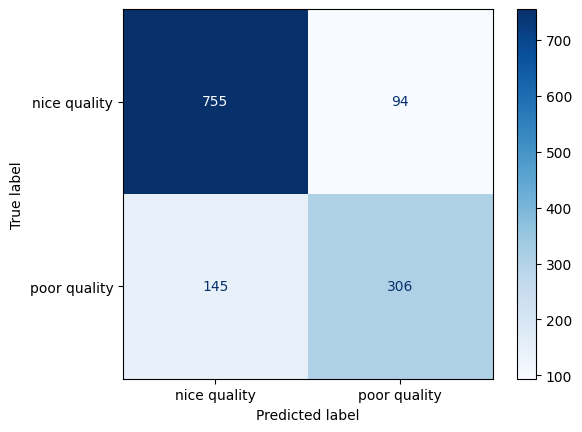

Classification Report:
              precision    recall  f1-score   support

nice quality       0.84      0.89      0.86       849
poor quality       0.77      0.68      0.72       451

    accuracy                           0.82      1300
   macro avg       0.80      0.78      0.79      1300
weighted avg       0.81      0.82      0.81      1300



In [14]:
# Using the best estimator for predictions
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

from sklearn import metrics

# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

The performance metrics shows that in general the model has an 82% of accuracy and a 0.79 as a general f1-score. This means that the model is able to classify the quality of the wine with a good accuracy. However, taking a look at the statistics for each label, we can see that the model is better at classifying the quality of the wine `nice quality` but both of them have a good performance.

**Conclusion**: The kNN model might be a good model.

### Final decision

Here we mention the best model.